###VGG16 
Architcture

Connecting to Google Drive

In [ ]:
# Connect to Google Drive to access dataset
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
training_path = r"/content/gdrive/MyDrive/DATASET/Training"
testing_path = r"/content/gdrive/MyDrive/DATASET/Testing"
validation_path = r"/content/gdrive/MyDrive/DATASET/Validation"

# Importing Libraries

In [ ]:
import os
from pathlib import Path

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Image-Preprocessing

In [ ]:

classes = os.listdir(training_path)
classes

['malignant', 'benign', 'normal']

In [ ]:
paths = Path(training_path)

#paths.glob('**/*.png') is used to get all the file paths of png images recursively in the paths 
path_images = list(paths.glob('**/*.png'))
images_paths = [str(path_image) for path_image in path_images ]
print(f'Number of training images: {len(images_paths)}')

#creates a list labels which contains the label of each image in the images_paths list
labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]

Number of training images: 623


Random Training Images: 


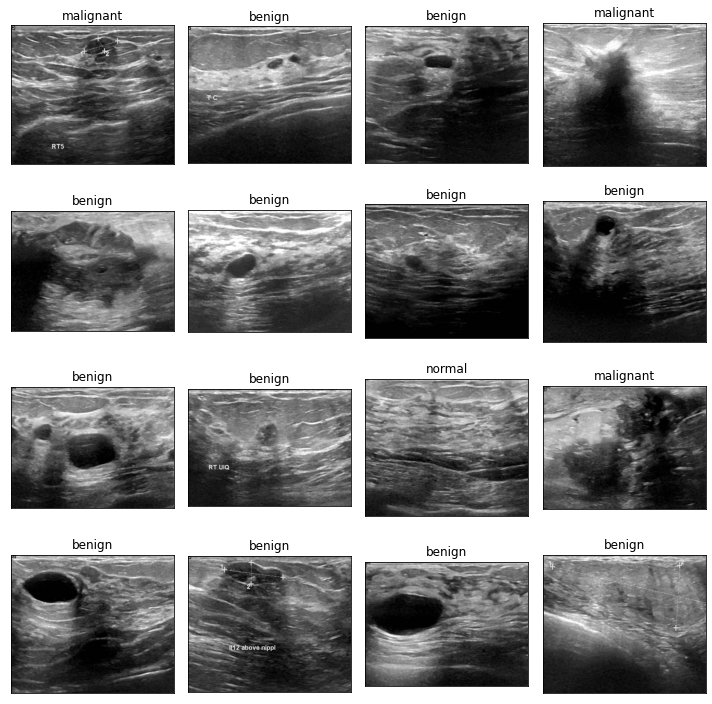

In [ ]:

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(images_paths), 16)
fig, axes = plt.subplots(4,4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Random Training Images: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_paths[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.tight_layout()
plt.show()

#Normalization

In [ ]:
pretrained_size = 224
pretrained_means = [0.5]
pretrained_stds = [0.5]

train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

valid_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])
train_dataset1 = torchvision.datasets.ImageFolder(root= training_path, transform = train_transforms)

In [ ]:
transforms2 = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])
train_dataset2 = torchvision.datasets.ImageFolder(root= training_path, transform = transforms2)

In [ ]:
transforms3 = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])
train_dataset3 = torchvision.datasets.ImageFolder(root= training_path, transform = transforms3)

In [ ]:
transforms4 = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])
train_dataset4 = torchvision.datasets.ImageFolder(root= training_path, transform = transforms4)

# Splitting the Dataset

In [ ]:
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4])
test_dataset = torchvision.datasets.ImageFolder(root= testing_path, transform = test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root= validation_path, transform = valid_transforms)

In [ ]:
len(train_dataset)

2492

In [ ]:
len(test_dataset)

155

In [ ]:
len(valid_dataset)

154

In [ ]:
# Hyper parameters
epochs = 30
num_classes = 3
batch_size = 32
learning_rate = 0.001

In [ ]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True,num_workers=2)
valid_loader = DataLoader(dataset = valid_dataset,  batch_size = batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

# Designing a Convolution Neural Network (CNN): 

In [ ]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions

VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG16"])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

In [ ]:
model = VGG_net()
print(model)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

# Loss & Optimization

In [ ]:
model = VGG_net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

#Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  

In [ ]:
%%time
# keeping-track-of-losses and accuracy
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1, epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss and accuracy
        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        train_acc += torch.sum(pred == target.data)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss and accuracy
        valid_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        valid_acc += torch.sum(pred == target.data)
    
    # calculate-average-losses and accuracy
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(100. * train_acc/len(train_loader.sampler))
    valid_accuracies.append(100. * valid_acc/len(valid_loader.sampler))
        
    # print-training/validation-statistics 
    print('Epoch: [{}/{}] \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
        epoch, epochs, train_loss, valid_loss,))
    print('Training Accuracy: {:.6f}% '.format(
         train_accuracies[-1]))
    print('Validation Accuracy: {:.6f}%\n'.format(
         valid_accuracies[-1]))

Epoch: [1/30] 	Training Loss: 2.757373 	Validation Loss: 0.904436 
Training Accuracy: 51.243980% 
Validation Accuracy: 60.000000%

Epoch: [2/30] 	Training Loss: 1.001178 	Validation Loss: 0.817274 
Training Accuracy: 57.744781% 
Validation Accuracy: 56.129032%

Epoch: [3/30] 	Training Loss: 1.026835 	Validation Loss: 0.818421 
Training Accuracy: 57.423756% 
Validation Accuracy: 66.451614%

Epoch: [4/30] 	Training Loss: 0.961215 	Validation Loss: 0.754252 
Training Accuracy: 59.711075% 
Validation Accuracy: 65.806450%

Epoch: [5/30] 	Training Loss: 0.964250 	Validation Loss: 0.781638 
Training Accuracy: 59.269665% 
Validation Accuracy: 56.129032%

Epoch: [6/30] 	Training Loss: 1.038943 	Validation Loss: 0.806879 
Training Accuracy: 57.423756% 
Validation Accuracy: 67.096771%

Epoch: [7/30] 	Training Loss: 1.035308 	Validation Loss: 0.797225 
Training Accuracy: 57.423756% 
Validation Accuracy: 65.161293%

Epoch: [8/30] 	Training Loss: 0.931341 	Validation Loss: 0.795511 
Training Accurac

# Validation

In [ ]:
# Connect to Google Drive to access dataset
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# saving model
torch.save(model.state_dict(), '/content/gdrive/MyDrive/VGG16_Updated_85.pth')

In [ ]:
valid_acc1 =  [float(i.cpu()) for i in valid_accuracies]
train_acc1 =  [float(i.cpu()) for i in train_accuracies]

In [ ]:
df = pd.DataFrame({
    'Epochs': range(1, 31),
    'Train loss': train_losses,
    'Valid loss': valid_losses,
    'Train acc': train_acc1,
    'Valid acc': valid_acc1,
})

In [ ]:
df.to_csv("VGG16_85.csv", index = True)

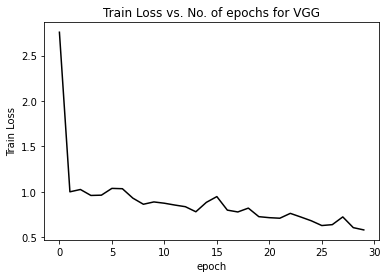

In [ ]:
plt.plot(train_losses, label='Training loss', color = 'black')
plt.xlabel('epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs. No. of epochs for VGG');

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(1,1, figsize = (15,9))

ax = plt.subplot(1,1,1)
ax.plot(train_losses, label='Training loss', color = 'black')
ax.plot(valid_losses, label='Validation loss', color = 'blue')
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)

ax1 = ax.twinx()
ax1.plot(train_acc1, label = "Training Acc", color = 'red')
ax1.plot(valid_acc1, label = 'Validation Acc', color = 'green')
ax1.set_ylabel("ACCURACY")

ax1.legend(loc = 'upper center', fontsize = 15)
ax.legend(loc = 'lower center', fontsize = 15)

fig.savefig("TrainingVsValidation_VGG16.png",dpi = 500, bbox_inches = 'tight')

In [ ]:
import numpy

In [ ]:
preds = []
target = []
probabilities = []
individual_prob = []

for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = nn.Softmax(dim=1)(outputs)
            prob, predicted = torch.max(outputs.data, 1)
            #Tensor from GPU to CPU by converting pytorch numpy to tensor array
            predicted = predicted.cpu().numpy()
            outputs = outputs.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
            labels = labels.cpu().numpy()
            preds.append(predicted)
            target.append(labels)
            #Finding probabilies for each probabilities
            probabilities.append(list(outputs))
            individual_prob.append(list(prob))
            
        

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Converting 2-D into 1-D array

In [ ]:
probabilities1 = []
for i in probabilities:
  for j in i:
    probabilities1.append(j)

In [ ]:
individual_prob1 = []
for i in individual_prob:
  for j in i:
    individual_prob1.append(j)

In [ ]:
preds1 = []
for i in preds:
  for j in i:
    preds1.append(j)

In [ ]:
target1 = []
for i in target:
  for j in i:
    target1.append(j)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(target1,preds1))

In [ ]:
confusion_matrix(target1,preds1)

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn .metrics import roc_auc_score, roc_curve
import seaborn as sns


In [ ]:
def plot_cm(confusion):
  sns.heatmap(confusion, annot=True,  square=True)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix', size=18)
  plt.tight_layout()

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(target1, preds1, labels=[0,1,2])
plot_cm(confusion)

In [ ]:
auc = np.round(roc_auc_score(target1, probabilities1, multi_class = 'ovr'), 3)
print("Auc score for our sample data is {}". format(auc))

In [ ]:
probabilities2 = np.array([i for i in probabilities1])

In [ ]:
def plot_multiclass_roc(y_score, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    threshold = dict()

    for i in range(n_classes):    
      fpr[i], tpr[i], threshold[i] = roc_curve(target1, probabilities2[:,i], pos_label=i)
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label = 'class '+ str(i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(probabilities2, target1, n_classes=3, figsize=(12,8))